In [1]:
import spacy
import csv
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc
from sklearn.preprocessing import StandardScaler

nlp = spacy.load("en_core_web_sm", exclude=['tok2vec', 'parser', 'senter', 'ner'])


In [2]:
def filterType(token):
    return token.is_alpha and not (token.is_stop or token.like_num or token.is_punct) and len(token.lemma_) > 3

In [3]:
with open('./covid19_preprints/data/covid19_preprints.csv') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    docs = [[token.lemma_ for token in doc if filterType(token)] for doc in nlp.pipe((row["abstract"] for row in csvreader), batch_size=1000, n_process=3)]
dictionary = Dictionary(docs)
dicted_docs = [dictionary.doc2bow(text) for text in docs]
lda = LdaMulticore(dicted_docs, id2word=dictionary, num_topics=10)

In [7]:
topics = corpus2csc(lda[dicted_docs]).T
topics_normalized = StandardScaler().fit_transform(topics.todense())

In [8]:
lda.show_topics()

[(0,
  '0.019*"patients" + 0.007*"sars" + 0.007*"study" + 0.006*"data" + 0.005*"severe" + 0.005*"clinical" + 0.005*"results" + 0.004*"cases" + 0.004*"pandemic" + 0.004*"mortality"'),
 (1,
  '0.012*"sars" + 0.006*"virus" + 0.006*"study" + 0.005*"patients" + 0.005*"high" + 0.005*"disease" + 0.005*"cases" + 0.004*"pandemic" + 0.004*"infection" + 0.004*"coronavirus"'),
 (2,
  '0.024*"sars" + 0.006*"data" + 0.005*"pandemic" + 0.005*"study" + 0.005*"time" + 0.005*"health" + 0.005*"disease" + 0.005*"infection" + 0.005*"patients" + 0.004*"clinical"'),
 (3,
  '0.016*"sars" + 0.007*"based" + 0.006*"pandemic" + 0.006*"results" + 0.005*"infection" + 0.005*"virus" + 0.005*"data" + 0.004*"coronavirus" + 0.004*"health" + 0.004*"disease"'),
 (4,
  '0.012*"health" + 0.008*"data" + 0.008*"infection" + 0.007*"study" + 0.007*"model" + 0.006*"sars" + 0.006*"social" + 0.006*"pandemic" + 0.005*"disease" + 0.004*"number"'),
 (5,
  '0.020*"patients" + 0.008*"sars" + 0.007*"disease" + 0.007*"data" + 0.006*"pand

In [23]:
lda.get_document_topics(dicted_docs, minimum_probability=0)[0]

[(0, 0.0019703456),
 (1, 0.0019702665),
 (2, 0.0019702686),
 (3, 0.0019702336),
 (4, 0.0019702588),
 (5, 0.0019703167),
 (6, 0.0019702318),
 (7, 0.0019702145),
 (8, 0.001970205),
 (9, 0.9822677)]

In [9]:
from sklearn.manifold import TSNE
twod = TSNE(n_components=2, n_jobs=-1).fit_transform(topics_normalized)

In [10]:
%%time
import umap
import umap.plot
reducer = umap.UMAP()
embedding = reducer.fit_transform(topics_normalized)

CPU times: user 13min 9s, sys: 4min 49s, total: 17min 58s
Wall time: 2min 14s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

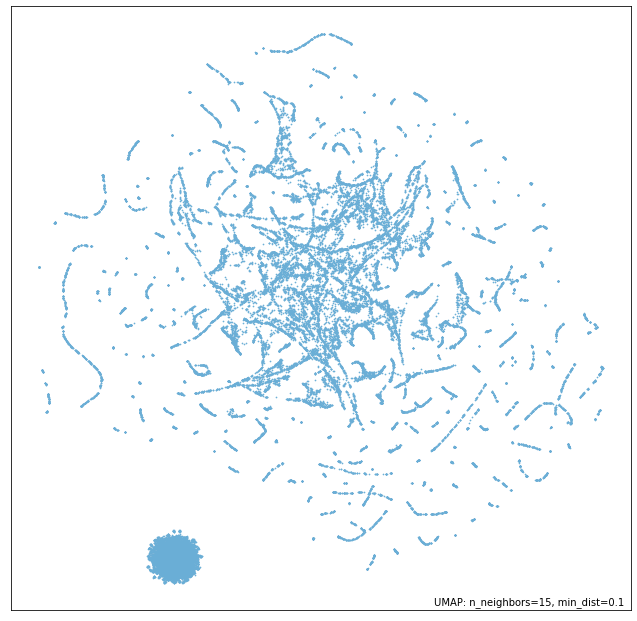

In [11]:
umap.plot.points(reducer)

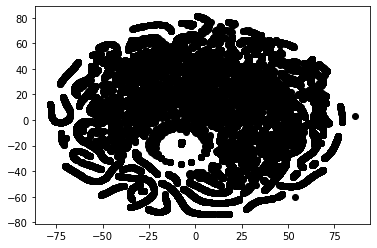

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(twod[:,0], twod[:,1], 'o', color='black');

In [29]:
import json
with open('./covid19_preprints/data/covid19_preprints.csv') as csvfile:
    with open('./data/extended_covid_preprints.json', 'w+') as jsonfile:
        csvreader = csv.DictReader(csvfile)
        
        projects = [
            {
                "tsne_coordinates":tsnecoord, 
                "umap_coordinates": umapcoord, 
                "topic_affiliation": [(num, float(topic)) for num,topic in topic_affiliation],
                **row
            } 
            for row, tsnecoord, topic_affiliation, umapcoord 
            in zip(csvreader, twod.tolist(), lda.get_document_topics(dicted_docs, minimum_probability=0), embedding.tolist())
        ]
        
        

        json.dump({
            "lda_topics": [[(word, float(importance))for word, importance in topic] for num,topic in lda.show_topics(formatted=False)],
            "projects": projects
        }, jsonfile)